## Text analysis

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import random
from random import sample 
import pandas as pd
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud
import os
import json
from tqdm import tqdm
import networkx as nx
import pickle
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open(r"LargeData\Graph2.pkl", 'rb') as file:
    graph = pickle.load(file)

In [60]:

flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]
extended_flair_list = flair_list + ["type-special","submissions"]

mention_dict = {}
id_dict = {}
text_dict = {}
for flair in flair_list:
    temp_dict = {}
    temp_dict_id = {}
    temp_dict_text = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = 0
        temp_dict_id[temp_flair] = []
        temp_dict_text[temp_flair] = []
    

    mention_dict[flair] = temp_dict 
    id_dict[flair] = temp_dict_id
    text_dict[flair] = temp_dict_text

for edge in graph.edges:
    author = edge[0]
    addressee = edge[1]

    author_flair = graph.nodes[author]['flair']

    #Check if node is empty
    if graph.nodes[addressee] == {}:
        continue
    addressee_flair = graph.nodes[addressee]['flair']
    if author_flair not in flair_list: 
        continue

    mention_dict[author_flair][addressee_flair] += 1
    id_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment_id'])
    text_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment'])

for node in graph.nodes:
    if graph.nodes[node] == {}:
        continue
    author_flair = graph.nodes[node]['flair']
    if author_flair not in flair_list: 
        continue
    mention_dict[author_flair]["submissions"] += len(graph.nodes[node]['submissions_id'])
    id_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions_id'])
    text_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions'])


In [114]:
graph.nodes[node]['submissions_id']

['h85t97f']

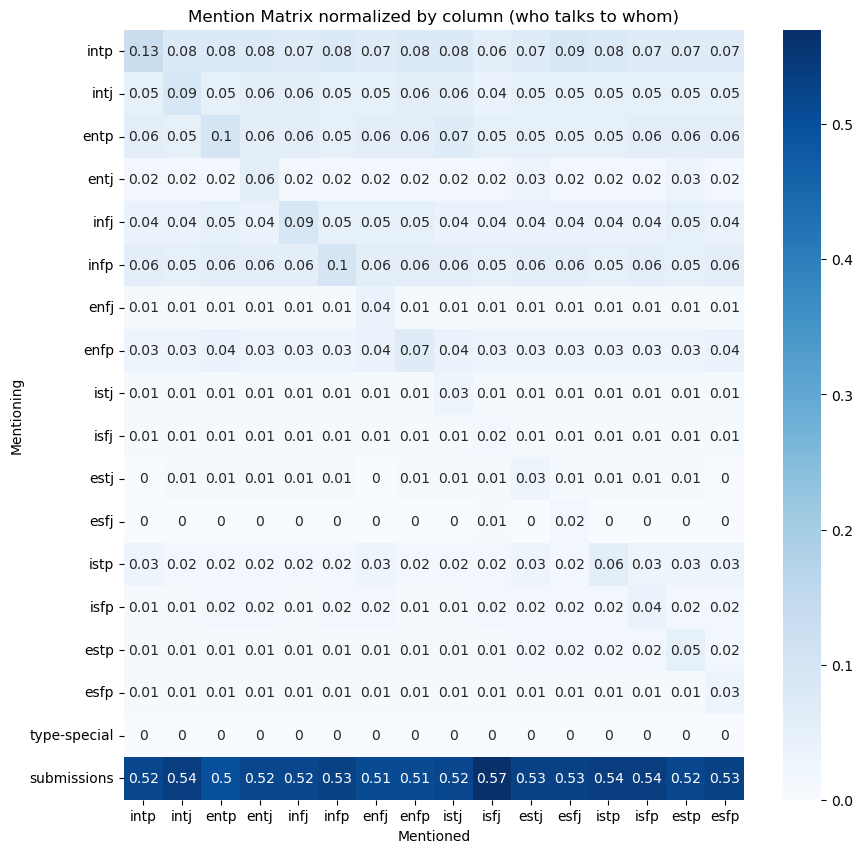

In [62]:
# plot mention matrix

mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=0), axis=1).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by column (who talks to whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()


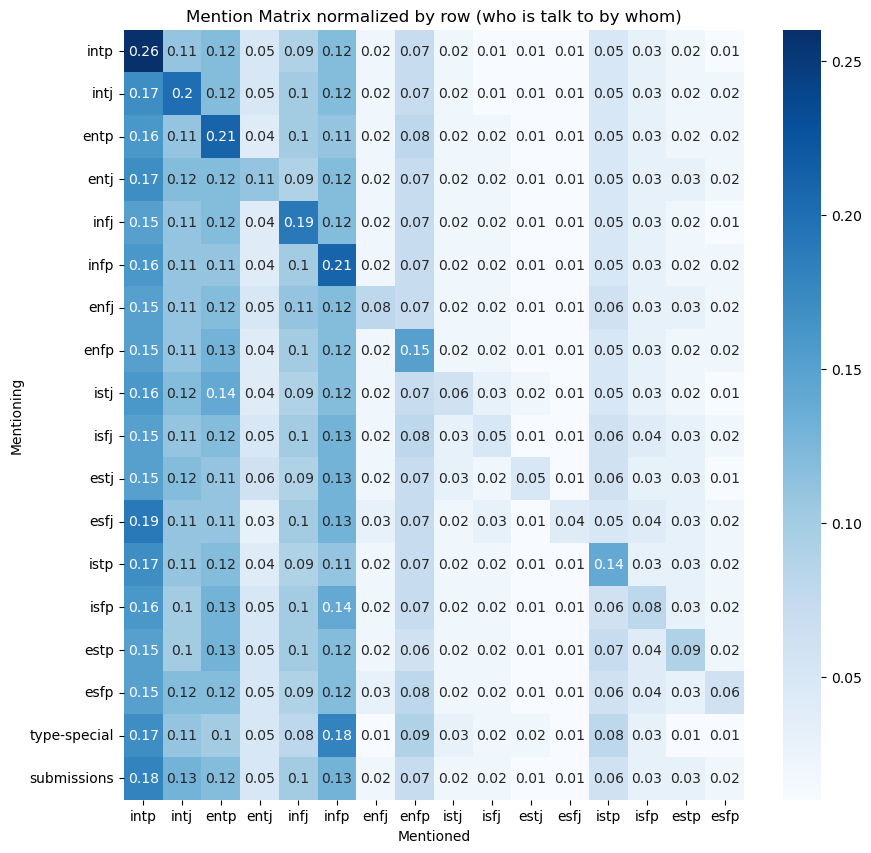

In [63]:
mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=1), axis=0).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by row (who is talk to by whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

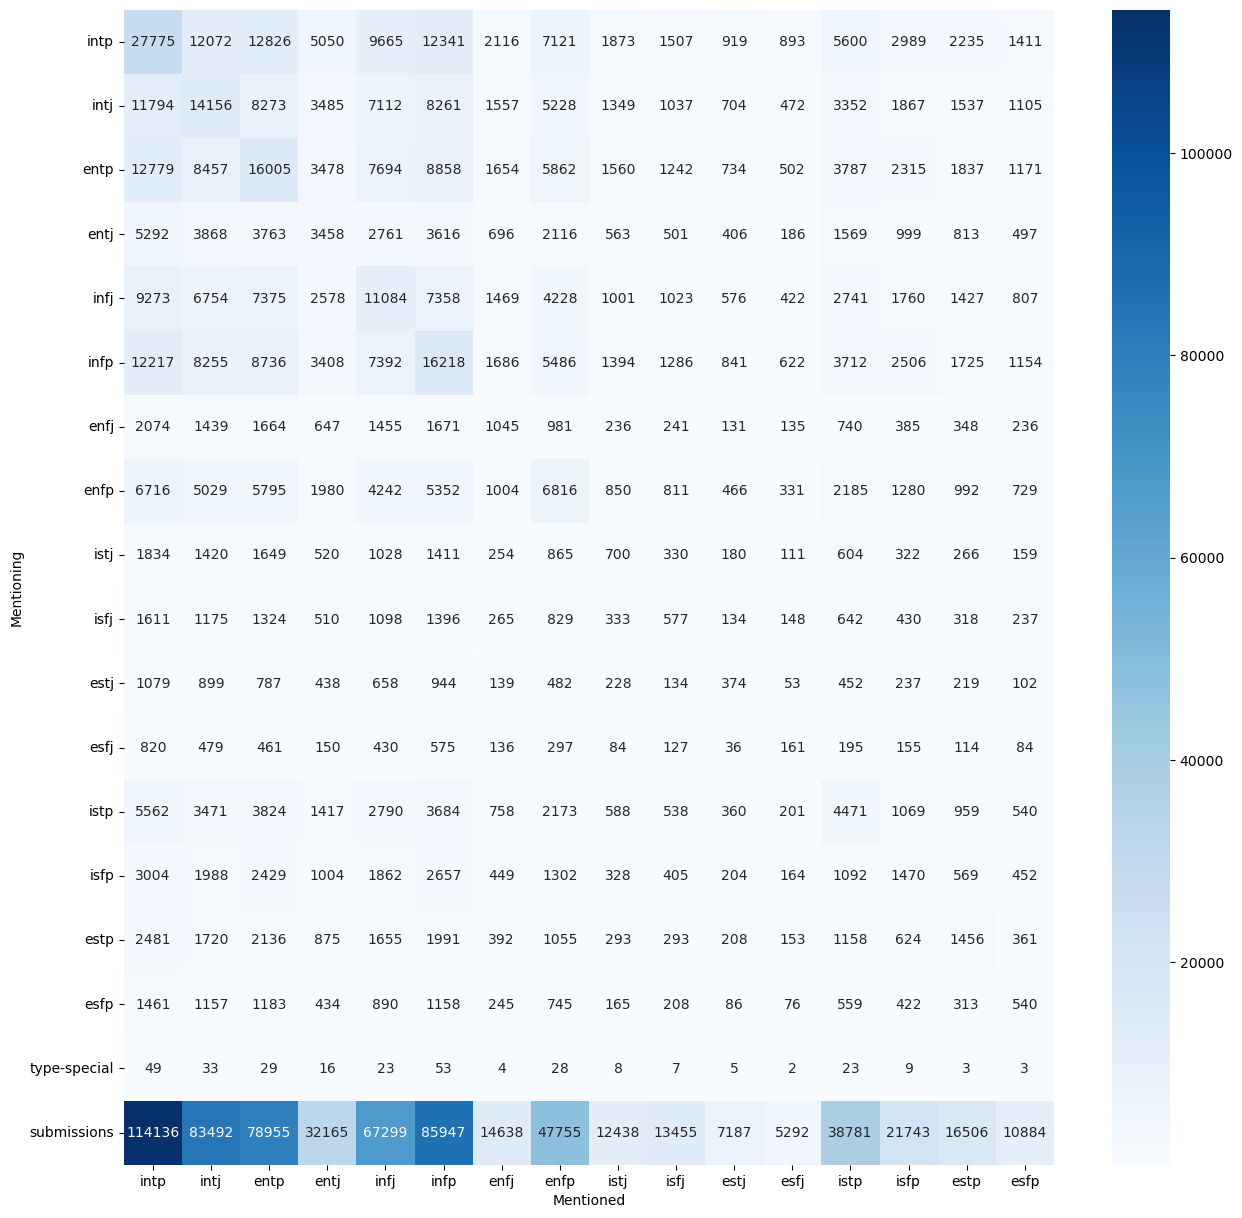

In [64]:
mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places

plt.figure(figsize=(15,15))
sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()


# Mentioned Sentiment

In [96]:
#Load sentiment dictionary
sentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")
sentiment_score=sentiment_frame.to_dict()["happiness_average"]

#Calculate mean sentiment of each post
def calculate_sentiment(text, sentiment_dict):
    sentiment = []
    for doc in text:
        temp_list = [] 
        for word in doc:
            if word in sentiment_dict:
                temp_list.append(sentiment_dict[word])
        if len(temp_list) == 0:
            continue
        else:
            sentiment.append(np.mean(temp_list))
    return sentiment



<BarContainer object of 16 artists>

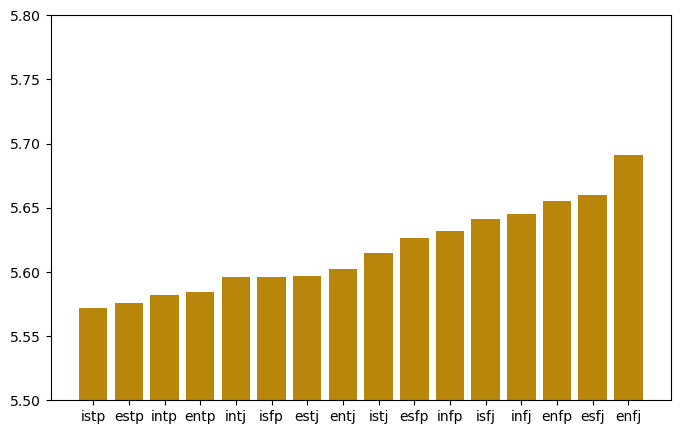

In [97]:
# Sentiment of each flair
sentiment_list =  []

for flair in flair_list:
    temp_list = []
    for temp_flair in extended_flair_list:
        temp_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
    sentiment_list.append(np.mean(temp_list))

# sort lexical diversity and flair list
sentiment_list, tmp_flair_list = zip(*sorted(zip(sentiment_list, flair_list)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))

#Rescale y axis
plt.ylim(5.5, 5.8)

plt.bar(tmp_flair_list, sentiment_list, color='darkgoldenrod')

In [106]:
#Make sentiment dictionary
sentiment_dict = {}
for flair in flair_list:
    temp_dict = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = np.mean(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score)) 
    sentiment_dict[flair] = temp_dict

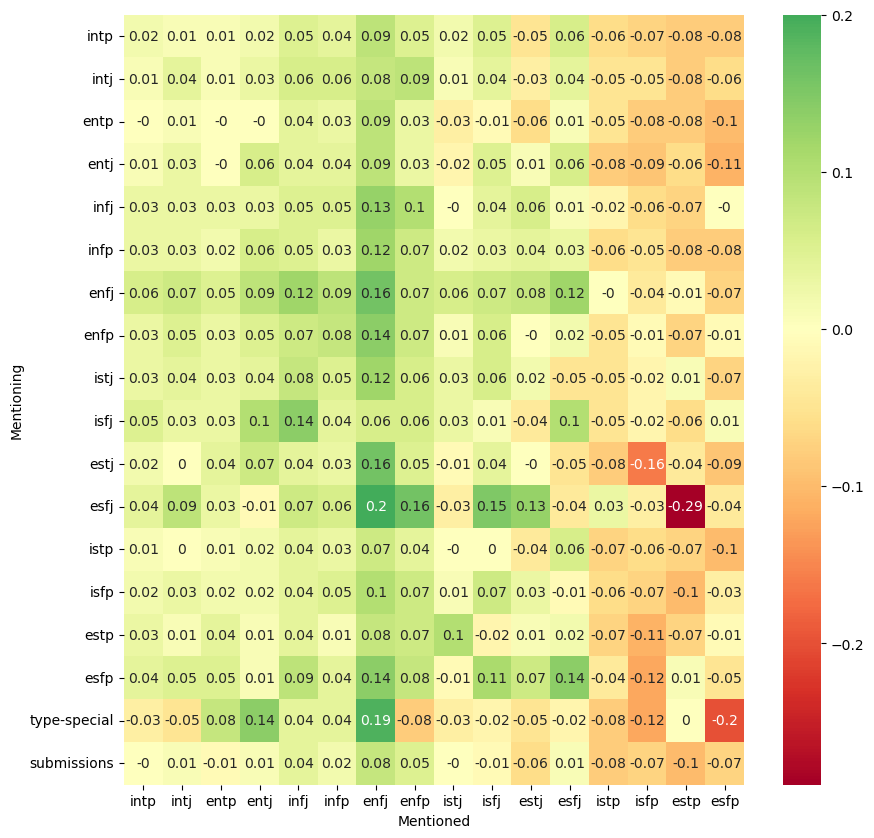

In [111]:
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

mention_matrix = pd.DataFrame.from_dict(sentiment_dict)

mention_matrix = mention_matrix.round(2)


#Subtract mean sentiment of each flair from each cell
for flair in flair_list:
    mention_matrix[flair] = mention_matrix[flair] - sentiment_list[flair_list.index(flair)]


mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(10,10))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='RdYlGn', center=0)
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

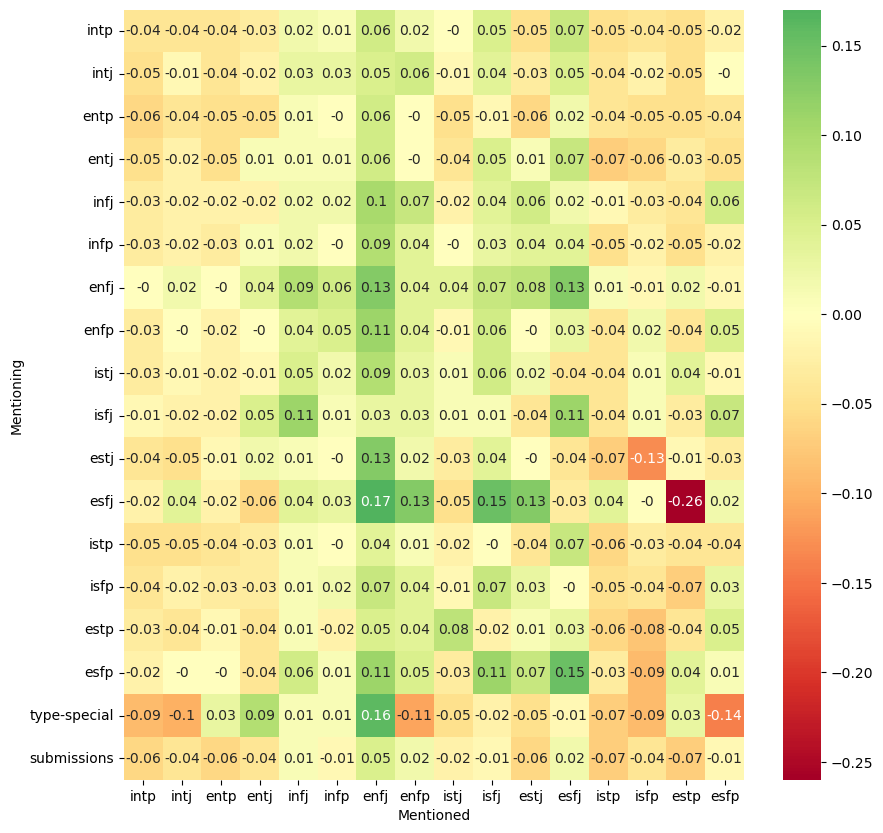

In [113]:
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

mention_matrix = pd.DataFrame.from_dict(sentiment_dict)

mention_matrix = mention_matrix.round(2)

"""
#Subtract mean sentiment of each flair from each cell
for flair in flair_list:
    mention_matrix[flair] = mention_matrix[flair] - sentiment_list[flair_list.index(flair)]
"""
mention_matrix = mention_matrix.subtract(mention_matrix.mean().mean(), axis=1)

mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(10,10))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='RdYlGn', center=0)
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

In [112]:
mention_matrix.mean()

intp    0.022222
intj    0.026667
entp    0.026111
entj    0.041667
infj    0.061111
infp    0.043889
enfj    0.116667
enfp    0.059444
istj    0.008889
isfj    0.040000
estj    0.006667
esfj    0.028333
istp   -0.051111
isfp   -0.068333
estp   -0.068889
esfp   -0.064444
dtype: float64

In [12]:
# plot mention matrix
for flair in flair_list:
    temp_dict = {}
    for temp_flair in flair_list:
        temp_dict[temp_flair] = calculate_sentiment_std(mention_dict[flair][temp_flair],sentiment_dict)
    mention_dict[flair] = temp_dict 
    
mention_matrix = pd.DataFrame.from_dict(mention_dict)

mention_matrix = mention_matrix.round(2)

#remove last row and column
mention_matrix = mention_matrix.iloc[:-1,:-1]

plt.figure(figsize=(10,10))
sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

NameError: name 'calculate_sentiment_std' is not defined

In [ ]:
print(id_dict["intp"]["type-special"])

['ezb0wda', 'f6qj2xh', 'f0z2kou', 'f0z7a2y', 'fixobqk', 'evsqdjc', 'evsyzxp', 'f08dw6s', 'f28pz50', 'fmkn4ak', 'flku61n', 'fm1xqak', 'f0uvg8c', 'exqobko', 'f0ebw0l', 'ey46faa', 'fgscuef', 'fdapqqm', 'fddl3w4', 'fhsdz7u', 'fkg71cl', 'fohhchv', 'fnay1tf', 'ev0933z', 'ev1gkfd', 'ex9wdxo', 'f31b4ob', 'f33gpjv', 'f8mwb3t', 'faeg2u7', 'fib2o3z', 'ffe7z8k', 'fjx3ofh', 'ffmi1l3', 'fgdfik3', 'fhd8ft9', 'fj55ggt', 'fibk6g7', 'fio4fxl', 'fj56k01', 'fj8iosr', 'flv7fi9', 'fki421b', 'fonpq0z', 'fmsm20l', 'fn3amtn', 'fnofhth', 'fo606o5', 'foiep19']


In [ ]:
print(id_dict["entp"]["isfj"])

['d56p2q8', 'd56pz9g', 'd56qg8h', 'd52jznz', 'd3tie3m', 'dbrt7c1', 'dbrv1uv', 'dpk7z7r', 'gbxzdno', 'dq08vhw', 'd3w19rw', 'd3w78mj', 'd3w7ecr', 'd5p0k7j', 'ddve8m4', 'd6zltxe', 'd6zmcle', 'd6zvdy4', 'd53r066', 'd53r8ld', 'd92umnn', 'df33jzo', 'd9qxa2x', 'dcp6ofr', 'ddv53l2', 'ej3up5c', 'de5da1s', 'dvgebgu', 'd5ot1ij', 'd5ots5g', 'd5ow5ki', 'd723xka', 'd9z7kpk', 'd5pd64u', 'd9negh0', 'd9on8ps', 'd9ooqle', 'fm1gfo8', 'd7nvsda', 'd7nz5xo', 'd7oj88o', 'daupjft', 'd71zbjc', 'dbp01yu', 'dbsykyu', 'dbtuy4c', 'dk2dh50', 'dk4bdtc', 'd8dihkb', 'd8fxrn9', 'd8fyqvd', 'd8j74bs', 'd8pjw7a', 'd8vzt87', 'de5sfse', 'dernuq7', 'dfoi8zz', 'd9g7e7c', 'dajvaiv', 'dee2mg6', 'dee6he6', 'deefsgl', 'dl87ls2', 'd9gstcv', 'djt9rk2', 'djta18c', 'da2v3ei', 'dacfnzx', 'dau8243', 'db2mlvp', 'dba6vsa', 'defgq09', 'dehcus3', 'dehhkx6', 'ddpedx7', 'degwbre', 'dew3kss', 'dezk964', 'deznq9w', 'ddplx50', 'dfgxu92', 'dfqbhl3', 'dfud3ki', 'dkynkh6', 'dfwbo5v', 'dfwccbq', 'dhegjw0', 'dhejus1', 'di3cjkw', 'di3dttj', 'di76rwl'

# Word cloud what is said

In [ ]:
flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]

mention_dict = {}
for flair in flair_list:
    temp_dict = {}
    for temp_flair in flair_list:
        temp_dict[temp_flair] = []
    mention_dict[flair] = temp_dict 

with open('links2022_clean' + '.ndjson',"r", encoding='utf-8') as f:
    for line in tqdm(f):
        post=json.loads(line)
        flair = post["flair"]
        comment = post["comment"]
        for word in comment:
            if word in flair_list:
                mention_dict[flair][word] += post["comment"]

FileNotFoundError: [Errno 2] No such file or directory: 'links2022_clean.ndjson'

In [ ]:
#Select talking flair
flair = "esfp"

word_dict = mention_dict[flair]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
names = list(word_dict.keys())
tf_idf= vectorizer .fit_transform([' '.join(list) for list in word_dict.values()])
word_list = vectorizer.get_feature_names_out()

In [ ]:
def tf_idf_to_string(tf_idf_matrix, word_list):
    feature_index = tf_idf_matrix.nonzero()[1]
    tfidf_scores = [(word_list[i], tf_idf_matrix[0, i]) for i in feature_index]
    tf_idf_string = ''
    for word, score in tfidf_scores:
        tf_idf_string += (word + ' ') * int(score * 100)  # Multiplying by 10 for better visualization
    return tf_idf_string

data_for_wordcloud = []
for i in range(16):
    data_for_wordcloud.append(tf_idf_to_string(tf_idf[i, :], word_list))

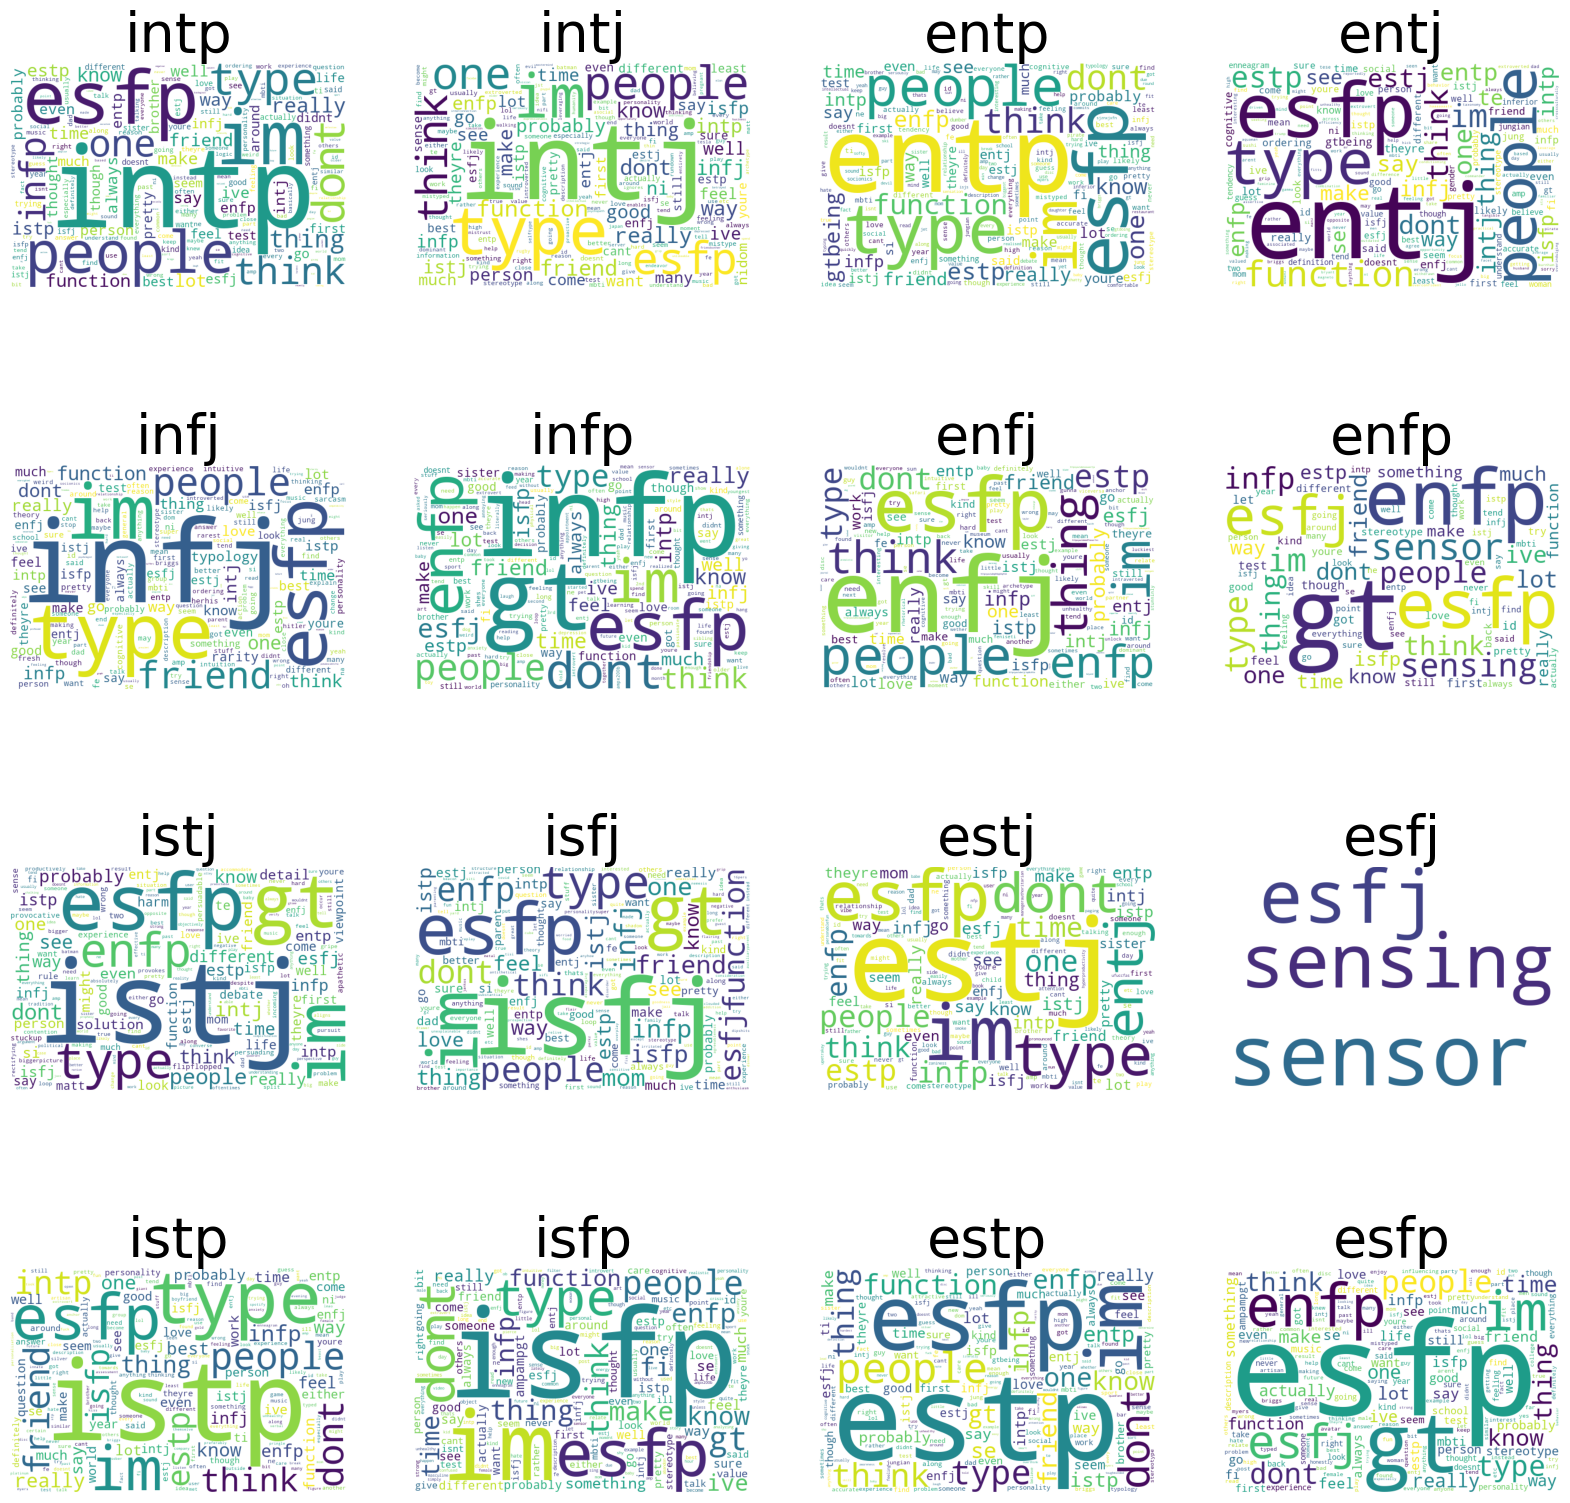

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=[20, 20])
for i in range(4):
    for j in range(4):

        wordcloud = WordCloud(background_color='white', width=600, height=400,collocations=False).generate(data_for_wordcloud[4*i+j])
        ax[i,j].imshow(wordcloud)
        ax[i,j].axis('off')
        ax[i,j].set_title(names[4*i+j],fontsize=40)
plt.show()

In [ ]:
author = "type-special"
adressed = "istj"
texts=mention_dict[flair][adressed]
print(" ".join(texts))

TypeError: can only join an iterable

# Arvage length of comment

In [ ]:
with open(r"LargeData\Graph.pkl", 'rb') as file:
    graph = pickle.load(file)

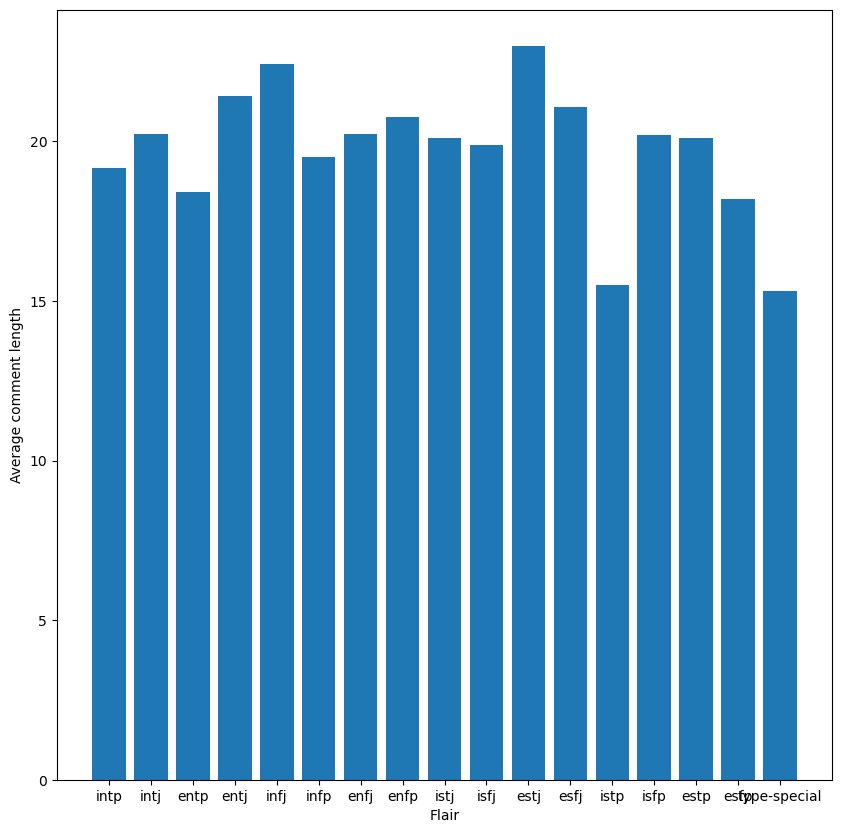

In [ ]:
for flair in flair_list:

    mention_dict[flair] = []

for node in graph.nodes:
    if graph.nodes[node] == {}:
        continue
    flair = graph.nodes[node]["flair"]
    mention_dict[flair]+=[len(comment) for comment in graph.nodes[node]["comments"]]

len_list=[]
for flair in flair_list:
    len_list.append(np.mean(mention_dict[flair]))

plt.figure(figsize=(10,10))
plt.bar(flair_list,len_list)
plt.xlabel('Flair')
plt.ylabel('Average comment length')
plt.show()

